# Table of Contents

- Setup 
    - Dataset and DataLoader
    - Training loop
    - Model architecture
- Model training

In [1]:
import torch
from torch import tensor, Tensor
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader

from utils import display_tensor_as_image, transform

## Setup

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'{device.type = }')

device.type = 'cpu'


### Dataset and DataLoader

In [3]:
mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_loader = DataLoader(dataset=mnist, batch_size=64, shuffle=True)

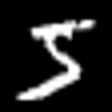

In [4]:
display_tensor_as_image(mnist[0][0])

### Training loop

In [5]:
from typing import Callable

def train_one_epoch(model: nn.Module, dataloader: DataLoader, loss_fn: Callable[[Tensor, Tensor], Tensor], optimizer: torch.optim.Optimizer) -> float:
    epoch_running_loss = 0

    for batch in dataloader:
        inputs, labels = batch

        inputs = inputs.to(device) #  move to GPU if available
        labels = labels.to(device) #  move to GPU if available

        optimizer.zero_grad() # zero gradients

        predictions = model(inputs)

        # compute loss and propogate gradients
        loss = loss_fn(predictions, labels)
        loss.backward()

        optimizer.step()

        # update metainformation
        epoch_running_loss += loss.item()

    epoch_avg_loss = epoch_running_loss / len(dataloader)
    return epoch_avg_loss


def train_n_epochs(n: int, model: nn.Module, dataloader: DataLoader, loss_fn: Callable[[Tensor, Tensor], Tensor], optimizer: torch.optim.Optimizer) -> None:
    for i in range(n):
        epoch_avg_loss = train_one_epoch(model, dataloader, loss_fn, optimizer)
        print(f'epoch {i}: {epoch_avg_loss = }')


### Model architecture

In [95]:
class CNN(nn.Module):
    '''
    Convolutional Neural Network
    '''
    def __init__(self, n_kernels, kernel_size):
        super(CNN, self).__init__()
        in_channels = 1 # grayscale image
        padding = int((kernel_size - 1) / 2) # this is the formula to preserve size assuming a stride of 1

        self.conv_1 = nn.Conv2d(in_channels=in_channels,
                                out_channels=n_kernels,
                                kernel_size=kernel_size,
                                stride=1,
                                padding=padding)
        self.pooling_1 = nn.MaxPool2d(kernel_size=2, stride=2) # this downsamples the input by factor of 2

        # n_weights_per_kernel = (kernel_size * kernel_size * in_channels) // 2 # after the downsampling
        # in_features = n_weights_per_kernel * n_kernels

        in_features = int(28 / 2) ** 2 # 28*28 gets downsampled to 14*14
        self.fully_connected_1 = nn.Linear(in_features, 10)

    def forward(self, x):
        print(f'{x.shape = }')
        x = self.conv_1(x)
        print(f'conv_1(x) =>             {x.shape = }')
        x = self.pooling_1(x)
        print(f'pooling_1(x) =>          {x.shape = }')
        x = x.flatten()
        print(f'x.flatten() =>           {x.shape = }')
        x = self.fully_connected_1(x)
        print(f'x.fully_connected_1() => {x.shape = }')
        return x

In [104]:
# x = torch.ones(1, 28, 28)

# m = CNN(1, 3)

# out = m(x)
# print(out.shape)
# out

x.shape = torch.Size([1, 28, 28])
conv_1(x) =>             x.shape = torch.Size([1, 28, 28])
pooling_1(x) =>          x.shape = torch.Size([1, 14, 14])
x.flatten() =>           x.shape = torch.Size([196])
x.fully_connected_1() => x.shape = torch.Size([10])
torch.Size([10])


tensor([-0.0750,  0.2866,  0.1940,  0.0928, -0.1657,  0.1932,  0.0901, -0.6652,
         0.0971,  0.1767], grad_fn=<AddBackward0>)

## Model training